In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import unquote
import requests
import re
import json
import config
from io import StringIO
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,8]
plt.rcParams["font.size"] = 14

pulls = pd.read_json("../data/datahub_pulls.jsonl", lines=True)
pulls.head()

,timestamp,url,user
0,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL
1,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL
2,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL
3,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL
4,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL


In [3]:
pulls["raw_repo_url"] = pulls["url"].str.split("repo=").str[1].str.split("&").str[0]
pulls.head()

,timestamp,url,user,raw_repo_url
0,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL,https://github.com/data-8/materials-sp19
1,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL,https://github.com/data-8/materials-su19
2,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL,https://github.com/data-8/materials-su19
3,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL,https://github.com/data-8/materials-su19
4,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL,https://github.com/data-8/materials-sp19


In [4]:
pulls["repo_url"] = pulls["raw_repo_url"].apply(lambda x: unquote(x) if type(x) != float else np.nan)
pulls.head()

,timestamp,url,user,raw_repo_url,repo_url
0,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL,https://github.com/data-8/materials-sp19,https://github.com/data-8/materials-sp19
1,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL,https://github.com/data-8/materials-su19,https://github.com/data-8/materials-su19
2,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL,https://github.com/data-8/materials-su19,https://github.com/data-8/materials-su19
3,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL,https://github.com/data-8/materials-su19,https://github.com/data-8/materials-su19
4,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL,https://github.com/data-8/materials-sp19,https://github.com/data-8/materials-sp19


In [ ]:
pulls["repo"] = pulls["repo_url"].str.split("/").str[-2:].str.join("/")

valid_repo_regex = r"^[\w-]+\/[\w-]+$"
pulls["repo"] = pulls["repo"].apply(lambda x: x if type(x) == str and re.search(valid_repo_regex, x) else np.nan)

pulls.head()

In [6]:
# pulls[~pulls["repo"].isna() & pulls["repo"].str.contains("/")]["repo"].unique()
pulls["org"] = pulls["repo"].str.split("/").str[0]
pulls.head()

,timestamp,url,user,raw_repo_url,repo_url,repo,org
0,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL,https://github.com/data-8/materials-sp19,https://github.com/data-8/materials-sp19,data-8/materials-sp19,data-8
1,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL,https://github.com/data-8/materials-su19,https://github.com/data-8/materials-su19,data-8/materials-su19,data-8
2,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL,https://github.com/data-8/materials-su19,https://github.com/data-8/materials-su19,data-8/materials-su19,data-8
3,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL,https://github.com/data-8/materials-su19,https://github.com/data-8/materials-su19,data-8/materials-su19,data-8
4,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NULL,https://github.com/data-8/materials-sp19,https://github.com/data-8/materials-sp19,data-8/materials-sp19,data-8


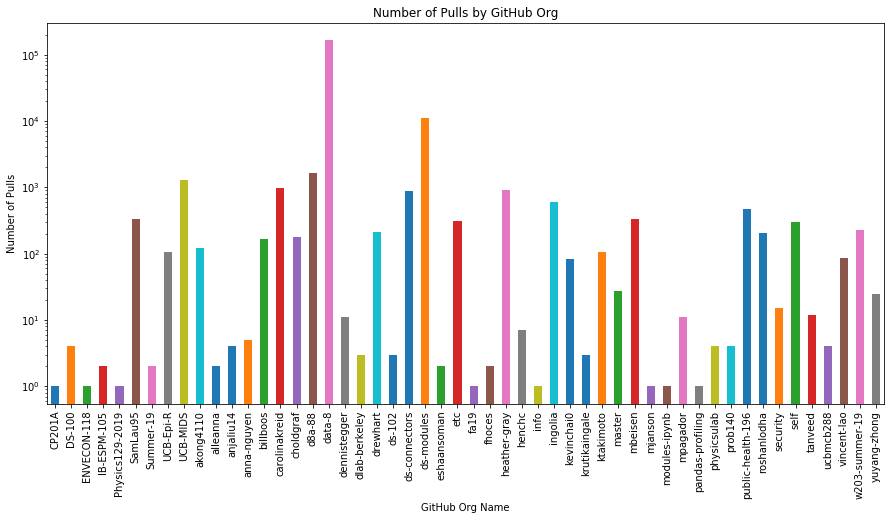

In [7]:
plt.figure(figsize=[15,7])
pulls.groupby("org")["repo"].count().plot.bar()
plt.yscale("log")
plt.xlabel("GitHub Org Name")
plt.ylabel("Number of Pulls")
plt.title("Number of Pulls by GitHub Org");

scrape to get repo data

In [9]:
def get_repo_info(repo):
    """Queries the GitHub API for repo metadata"""
    if type(repo) != str:
        return np.nan
    res = requests.get(
        "https://api.github.com/repos/{}".format(repo),
        headers = {
            "Authorization": "token {}".format(config.github_oauth_token)
        }
    )
    return json.load(StringIO(res.text))

In [26]:
# repos = pulls["repo"].unique()
# repo_info = {}
# for repo in repos:
#     repo_info[repo] = get_repo_info(repo)
    
# with open("../data/repo_info.json", "w+") as f:
#     json.dump(repo_info, f)
    
with open("../data/repo_info.json") as f:
    repo_info = json.load(f)

pulls["repo_info"] = pulls["repo"].apply(lambda x: repo_info[x] if type(x) == str else np.nan)
pulls.head()

,timestamp,url,user,raw_repo_url,repo_url,repo,org,repo_info,size_KB
0,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NaN,https://github.com/data-8/materials-sp19,https://github.com/data-8/materials-sp19,data-8/materials-sp19,data-8,"{'id': 165160688, 'node_id': 'MDEwOlJlcG9zaXRv...",73215.0
1,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NaN,https://github.com/data-8/materials-su19,https://github.com/data-8/materials-su19,data-8/materials-su19,data-8,"{'id': 192810356, 'node_id': 'MDEwOlJlcG9zaXRv...",38143.0
2,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NaN,https://github.com/data-8/materials-su19,https://github.com/data-8/materials-su19,data-8/materials-su19,data-8,"{'id': 192810356, 'node_id': 'MDEwOlJlcG9zaXRv...",38143.0
3,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NaN,https://github.com/data-8/materials-su19,https://github.com/data-8/materials-su19,data-8/materials-su19,data-8,"{'id': 192810356, 'node_id': 'MDEwOlJlcG9zaXRv...",38143.0
4,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NaN,https://github.com/data-8/materials-sp19,https://github.com/data-8/materials-sp19,data-8/materials-sp19,data-8,"{'id': 165160688, 'node_id': 'MDEwOlJlcG9zaXRv...",73215.0


In [27]:
pulls["size_KB"] = pulls["repo_info"].apply(lambda x: x["size"] if type(x) == dict and "size" in x else np.nan)
pulls.head()

,timestamp,url,user,raw_repo_url,repo_url,repo,org,repo_info,size_KB
0,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NaN,https://github.com/data-8/materials-sp19,https://github.com/data-8/materials-sp19,data-8/materials-sp19,data-8,"{'id': 165160688, 'node_id': 'MDEwOlJlcG9zaXRv...",73215.0
1,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NaN,https://github.com/data-8/materials-su19,https://github.com/data-8/materials-su19,data-8/materials-su19,data-8,"{'id': 192810356, 'node_id': 'MDEwOlJlcG9zaXRv...",38143.0
2,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NaN,https://github.com/data-8/materials-su19,https://github.com/data-8/materials-su19,data-8/materials-su19,data-8,"{'id': 192810356, 'node_id': 'MDEwOlJlcG9zaXRv...",38143.0
3,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NaN,https://github.com/data-8/materials-su19,https://github.com/data-8/materials-su19,data-8/materials-su19,data-8,"{'id': 192810356, 'node_id': 'MDEwOlJlcG9zaXRv...",38143.0
4,2019-07-09 12:00:00,/hub/user-redirect/git-sync?repo=https://githu...,NaN,https://github.com/data-8/materials-sp19,https://github.com/data-8/materials-sp19,data-8/materials-sp19,data-8,"{'id': 165160688, 'node_id': 'MDEwOlJlcG9zaXRv...",73215.0


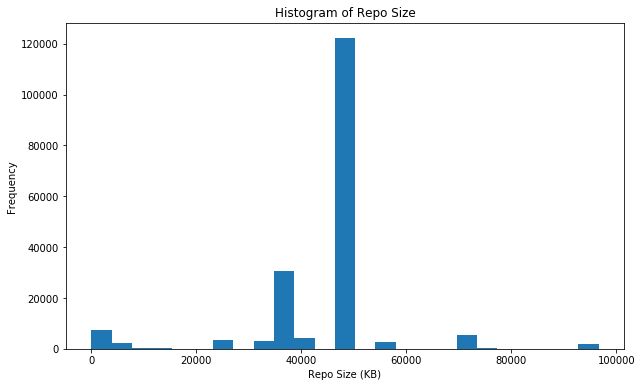

In [28]:
plt.figure(figsize=[10,6])
pulls[pulls["size_KB"] <= 125000]["size_KB"].plot.hist(bins=25)
plt.xlabel("Repo Size (KB)")
plt.title("Histogram of Repo Size");

KDE of size

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


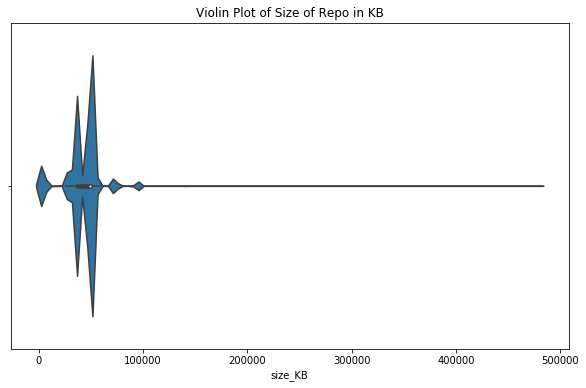

In [42]:
plt.figure(figsize=[10,6])
sns.violinplot(pulls["size_KB"])
plt.title("Violin Plot of Size of Repo in KB");

In [49]:
pulls[pulls["org"] == "IB-ESPM-105"]

,timestamp,url,user,raw_repo_url,repo_url,repo,org,repo_info,size_KB
96710,2019-09-11 03:00:00,/hub/user-redirect/git-pull?repo=https%3A%2F%2...,NaN,https%3A%2F%2Fgithub.com%2Fds-modules%2FIB-ESP...,https://github.com/ds-modules/IB-ESPM-105/fall...,IB-ESPM-105/fall2019,IB-ESPM-105,"{'message': 'Not Found', 'documentation_url': ...",NaN
98307,2019-09-11 17:00:00,/hub/user-redirect/git-pull?repo=https%3A%2F%2...,34ba6fc06bb2a0da5f0c1038cac42b96779ad042c2a916...,https%3A%2F%2Fgithub.com%2Fds-modules%2FIB-ESP...,https://github.com/ds-modules/IB-ESPM-105/fall...,IB-ESPM-105/fall2019,IB-ESPM-105,"{'message': 'Not Found', 'documentation_url': ...",NaN


In [44]:
pulls["org"].unique()

array(['data-8', nan, 'UCB-MIDS', 'ds-modules', 'choldgraf', 'henchc',
       'anna-nguyen', 'mpagador', 'self', 'etc', 'security', 'fhoces',
       'pandas-profiling', 'UCB-Epi-R', 'w203-summer-19', 'ktakimoto',
       'SamLau95', 'ucbmcb288', 'mjanson', 'billboos', 'ds-connectors',
       'master', 'Summer-19', 'ENVECON-118', 'heather-gray',
       'public-health-196', 'd8a-88', 'dennistegger', 'dlab-berkeley',
       'ingolia', 'fa19', 'DS-100', 'mbeisen', 'IB-ESPM-105',
       'Physics129-2019', 'prob140', 'ds-102', 'carolinakreid', 'CP201A',
       'yuyang-zhong', 'vincent-lao', 'krutikaingale', 'roshanlodha',
       'akong4110', 'alleanna', 'modules-ipynb', 'tanveed', 'physicsulab',
       'drewhart', 'info', 'kevinchai0', 'anjaliu14', 'eshaansoman'],
      dtype=object)

In [48]:
class_info = [
    {"class": "COMPSCI C8", "org": "data-8", "repo": "maertials-fa19", "size": 1318},
    {"class": "MCELLBI 292 288 - IND 288", "org": "ucbmcb288", "repo": np.nan, "size": 5},
    {"class": "PHW250F & PHW250G", "org": "UCB-Epi-R", "repo": np.nan, "size": 67 + 64},
    {"class": "EEP 118", "org": "ds-modules", "repo": "ENVECON-118", "size": 85 + 17},
    {"class": "PH 196 008", "org": "public-health-196", "repo": "ph196-fa19", "size": 40},
    {"class": "Data 88 001", "org": "d8a-88", "repo": "econ-fa19", "size": 26},
    {"class": "ESPM/IB C105", "org": "ds-modules", "repo": "IB-ESPM-105", "size": 17}
]